In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

# keras
from tensorflow import keras 
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import set_random_seed

# scipy
from scipy import sparse

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [3]:
from gensim.models import KeyedVectors
kv_model = KeyedVectors.load_word2vec_format('../utils/crawl-300d-2M.vec')

In [4]:
# def load_glove_model(File):
#   print("Loading Glove Model")
#   glove_model = {}
#   with open(File, 'r', encoding="utf8") as f:
#     for line in f:
#       split_line = line.split()
#       word = split_line[0]
#       embedding = np.array(split_line[1:], dtype=np.float64)
#       glove_model[word] = embedding
#   print(f"{len(glove_model)} words loaded!")
#   return glove_model

# GloveModel = load_glove_model('../utils/glove.twitter.27B.200d.txt')

In [5]:
set_random_seed(13)

In [6]:
X = np.load('../data/preprocessed_data/feature_vectors_normal.npy', allow_pickle=True)
y = np.load('../data/preprocessed_data/target_vectors_normal.npy', allow_pickle=True)

In [7]:
X_train_split, X_test_split, y_train, y_test = train_test_split(X, y, train_size=0.9, random_state=13)
X_test_split, X_val_split, y_test, y_val = train_test_split(X_test_split, y_test, train_size=0.5, random_state=13)

print("Train set size:", X_train_split.shape[0])
print("Test set size", X_test_split.shape[0])
print("Validation set size", X_val_split.shape[0])

Train set size: 1436333
Test set size 79796
Validation set size 79797


**GloVe word embeddings**

Let us begin by vectorizing `X` and `y`. Here, we use `keras`'s tokenizer because it allows us to preprocess the data in a simpler and more convenient fashion than Pytorch's `torchtext` or `pytorch-nlp`. 

In [8]:
# Initiate Keras tokenizer and vectorizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train_split)

# Transfrom X into vectorized values
X_train_transformed = tokenizer.texts_to_sequences(X_train_split)
X_val_transformed = tokenizer.texts_to_sequences(X_val_split)
X_test_transformed = tokenizer.texts_to_sequences(X_test_split)

# View vocabulary size
print("Vocabulary size: ", len(tokenizer.word_index))

Vocabulary size:  219191


In [9]:
# Initiate the label encoder to convert target data into (0, 1) instead of (0, 4)
label_encoder = LabelEncoder()

# Transform y into numerical values (0, 1)
y_train = label_encoder.fit_transform(y_train)
y_val = label_encoder.transform(y_val)
y_test = label_encoder.transform(y_test)

We are not yet finished. From the summary, it is quite noticeable that the lengths of the word vectors are largely uneven and deviating. This is why we should always consider padding/truncating during preprocessing. While this is not required for all deep learning model, uneven length in data may give the model a harder time to process batches and slow down the computation process. 

In [10]:
print('Statistics summary of vector lengths in X_transformed: ')
pd.Series([len(text.split()) for text in X]).describe(percentiles=[.25, .5, .75, .9, .975]).apply("{0:.2f}".format)

Statistics summary of vector lengths in X_transformed: 


count    1595926.00
mean          13.09
std            7.23
min            1.00
25%            7.00
50%           12.00
75%           19.00
90%           24.00
97.5%         27.00
max           53.00
dtype: object

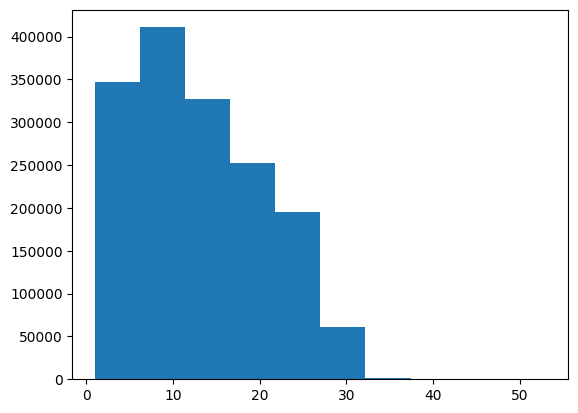

In [11]:
plt.hist([len(text.split()) for text in X])
plt.show()



For our case, we can see that the maximum size is quite short (50 tokens) so there is no need for truncation. However, padding will be performed to ensure that the vectors have the same length.

In [12]:
# Perform padding on X_transformed
X_train_transformed = pad_sequences(X_train_transformed, maxlen=25, padding='post', truncating='post')
X_val_transformed = pad_sequences(X_val_transformed, maxlen=25, padding='post', truncating='post')
X_test_transformed = pad_sequences(X_test_transformed, maxlen=25, padding='post', truncating='post')

print('Statistics summary of vector lengths in X_transformed: ')
pd.Series([len(text) for text in X_train_transformed]).describe().apply("{0:.2f}".format)

Statistics summary of vector lengths in X_transformed: 


count    1436333.00
mean          25.00
std            0.00
min           25.00
25%           25.00
50%           25.00
75%           25.00
max           25.00
dtype: object

In [13]:
train_set = TensorDataset(torch.tensor(X_train_transformed), torch.tensor(y_train).reshape(-1, 1))
val_set = TensorDataset(torch.tensor(X_val_transformed), torch.tensor(y_val).reshape(-1, 1))
test_set = TensorDataset(torch.tensor(X_test_transformed), torch.tensor(y_test).reshape(-1, 1))

train_loader = DataLoader(train_set, batch_size=128, shuffle=True)
val_loader = DataLoader(val_set, batch_size=128)
test_loader = DataLoader(test_set, batch_size=128)

Now, we may continue building the embedding word vectors from our built vocabulary. The idea is to loop through each item in our vocabulary to see for each word if GloVe has the embedding vectors for it. If yes, we may load it into our embeddings matrix; otherwise, we leave it as empty (fill with zeros).

In [14]:
# Obtain the vocabulary size of our data 
# (+1 is to add padding token, which is not initially included in the vocabulary)
VOCAB_SIZE = len(tokenizer.word_index) + 1

# Embedding size. This is the default dimensions of the GloVe's embeddings.
EMBEDDINGS_DIM = 300

OUTPUT_SIZE = 1
HIDDEN_SIZE = 512
BATCH_SIZE = 128
NUM_EPOCHS = 80

In [15]:
# Initiate an empty matrix as a embeddings container
embedding_matrix = np.zeros((VOCAB_SIZE, EMBEDDINGS_DIM))

# Loading GloVe weights into our embedding matrix
for word, index in tokenizer.word_index.items():
  if word in kv_model:
    embedding_matrix[index] = kv_model[word].copy()

embedding_matrix = torch.FloatTensor(embedding_matrix)

Let us look at the shape of the embedding matrix for dimensionality check. It should be (vocabulary size, embeddings dimension).

In [16]:
embedding_matrix.shape

torch.Size([219192, 300])

Recurrent neural network (RNN) model 

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [18]:
torch.manual_seed(13)
if torch.cuda.is_available():
  torch.cuda.manual_seed_all(13)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [19]:
class RNN(nn.Module):
  def __init__(self, output_size, embedding_dim, hidden_size, hidden_layer, dropout=0.2):
    self.embedding = nn.Embedding.from_pretrained(embedding_matrix)
    self.recurrent = nn.RNN(input_size=embedding_dim, 
             hidden_size=hidden_size, 
             num_layers=hidden_layer,
             nonlinearity='relu',
            #  dropout=dropout,
             bidirectional=True)
    self.out_layer = nn.Sequential(
      nn.Linear(in_features=hidden_layer, out_features=output_size),
      nn.Sigmoid()
    )

  def forward(self, input):
    emb = self.embedding(input)
    out, ht = self.recurrent_stack(emb, None)
    return out
  
model = RNN(OUTPUT_SIZE, EMBEDDINGS_DIM, HIDDEN_SIZE, 2)
print(model)

AttributeError: cannot assign module before Module.__init__() call

In [ ]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=0)

train_loss_arr = []
train_accu_arr = []
val_loss_arr = []
val_accu_arr = []

def train(model, train_loader, val_loader, train_set, val_set, criterion, optimizer, num_epochs=50):

  for epoch in range(num_epochs):
    total_train_loss = 0
    total_train_correct = 0
    
    model.train()
    for input, target in train_loader:
      if torch.cuda.is_available:
        input, target = input.to(device), target.to(device)
      
      output = model(input)

      loss = criterion(output, target)
      total_train_loss += loss.items()
      total_train_correct += ((output > 0.5)==target).sum()

    

